In [46]:
# Sentiment algorithm 1. Sequence of lemmas as single feature input and binary classification of sentence as output

# Model is saved in saved_models/model_name/model_variant.h5
# Run history is saved in logged_models/model_name sorted by model_variants and run-datetime
# Runs can be viewed using tensorboard: tensorboard --logdir=PATH --port=6006
# Example given: tensorboard --logdir=C:\BAC\Ezra\sentiment\models\logged_models\sent_algo_1 --port=6006
model_name = 'sent_algo_2'
model_variant = 'base'

training_size = 75000
test_size = 25000

In [47]:
# SETUP IMPORTS
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
import time
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from collections import Counter
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from keras import models
import os
import time
import tensorflow as tf
from keras import callbacks
pd.set_option('display.max_columns', 10, 'display.width', 10, 'display.max_colwidth', 20, 'display.max_rows',100)

In [48]:
# LOAD DATASET
df = pd.read_json('../datasets/sentiment_corpus.json')
print("Corpus sample size is:", len(df))

print(training_size, "samples are taken from the head for training")
print(test_size, "samples are taken from the tail for test")

# We take from the head for training data and tail for test data
# This is done since the last 25% of the corpus is not fitted on the polarity dict, thereby preventing overfitting
train_data = df.head(training_size)
test_data = df.tail(test_size)

train_data

Corpus sample size is: 4970467
75000 samples are taken from the head for training
25000 samples are taken from the tail for test


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,organizations,organization,NOUN,-0.223025,F
1,1,decided,decide,VERB,-0.039008,F
2,1,drop,drop,VERB,-0.058436,F
3,1,women,woman,NOUN,0.272143,F
4,1,accused,accuse,VERB,0.006282,F
...,...,...,...,...,...,...
74995,9735,meant,mean,VERB,-0.079156,M
74996,9735,disrespect,disrespect,NOUN,0.000000,M
74997,9737,Skiing,skiing,NOUN,0.000000,M
74998,9737,individual,individual,ADJ,-0.117658,M


In [49]:
# GROUP-BY SENTENCE NUMBER 
train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))

def gender_seq_to_single(seqs):
    genders = []
    for seq in seqs:
        genders.append(seq[0])
    return genders

train_data['Gender'] = gender_seq_to_single(train_data['Gender'])
test_data['Gender'] = gender_seq_to_single(test_data['Gender'])
train_data

C:\Users\hanse\AppData\Local\Temp/ipykernel_9848/2965456592.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  train_data = train_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))
C:\Users\hanse\AppData\Local\Temp/ipykernel_9848/2965456592.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  test_data = test_data.groupby(['Sentence #'],as_index=False)['Word', 'Lemma', 'POS', 'Polarity', 'Gender'].agg(lambda x: list(x))


,Sentence #,Word,Lemma,POS,Polarity,Gender
0,1,"[organizations, ...","[organization, d...","[NOUN, VERB, VER...",[-0.223024829414...,F
1,2,"[Women, previous...","[woman, previous...","[NOUN, ADV, VERB...",[0.2721428399909...,F
2,3,"[response, alleg...","[response, alleg...","[NOUN, NOUN, PRO...",[-0.028053754978...,F
3,4,"[aware, allegati...","[aware, allegati...","[ADJ, NOUN, PROPN]",[-0.015715441394...,F
4,5,"[point, Visa, su...","[point, Visa, su...","[NOUN, PROPN, VE...",[-0.228729956550...,F
...,...,...,...,...,...,...
8222,9731,"[return, discipl...","[return, discipl...","[VERB, ADJ, NOUN...",[-0.174658146948...,M
8223,9733,"[remarks, race, ...","[remark, race, s...","[NOUN, NOUN, NOU...","[0.0, -0.0718725...",M
8224,9734,"[team, event, sc...","[team, event, sc...","[NOUN, NOUN, VERB]",[-0.582462135797...,M
8225,9735,"[issued, apology...","[issue, apology,...","[VERB, NOUN, PRO...",[-0.136028259061...,M


In [50]:
# SHUFFLE TRAINING AND TEST DATA
train_data = train_data.sample(frac=1).reset_index(drop=True)
test_data = test_data.sample(frac=1).reset_index(drop=True)
train_data

,Sentence #,Word,Lemma,POS,Polarity,Gender
0,7518,"[Like, bubble, g...","[like, bubble, g...","[ADP, NOUN, NOUN...",[-0.129606102667...,M
1,6685,"[means, group, f...","[mean, group, fe...","[VERB, NOUN, ADJ...",[-0.079156230651...,M
2,1168,"[husbands, repor...","[husband, report...","[NOUN, VERB, VER...",[0.0502191080732...,F
3,3356,"[White, House, b...","[White, House, b...","[PROPN, PROPN, N...",[-0.025178845926...,M
4,3136,"[kit, person, us...","[kit, person, us...","[NOUN, NOUN, ADV...","[0.0, -0.0667200...",F
...,...,...,...,...,...,...
8222,3250,"[eyes, read, wor...","[eye, read, word...","[NOUN, VERB, NOU...",[0.0806295578346...,F
8223,9363,"[Virtue, didn, d...","[Virtue, didn, d...","[PROPN, PROPN, V...","[0.0, 0.0, 0.0, ...",M
8224,7823,"[don, agree, res...","[don, agree, res...","[VERB, VERB, VER...","[0.0, -0.0402947...",F
8225,7928,"[reportedly, tol...","[reportedly, tel...","[ADV, VERB, VERB...",[-0.014481969386...,F


<AxesSubplot:>

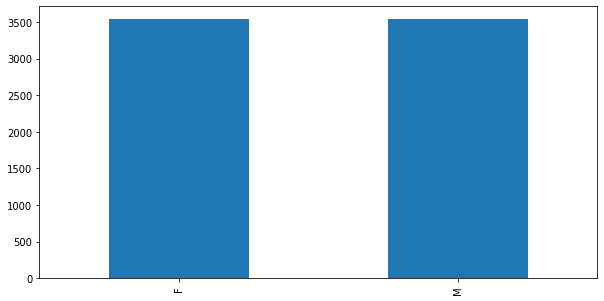

In [51]:
# EQUAL GENDER SAMPLES TO PREVENT BIAS
def equal_genders(data_):
    M, F = data_["Gender"].value_counts()
    if M>F:
        diff = M-F
        return data_.drop(data_.loc[data_['Gender'] == 'M'].index[:diff], axis=0)
    elif F>M:
        diff = F-M
        return data_.drop(data_.loc[data_['Gender'] == 'F'].index[:diff], axis=0)

train_data = equal_genders(train_data)
test_data = equal_genders(test_data)

train_data["Gender"].value_counts().plot(kind="bar", figsize=(10,5))

In [52]:
# DEFINE FUNCTION FOR PLOTTING SENTENCE LENGTHS
def plot_sentence_lengths(data_):
    sentence_plot = data_["Word"].values
    sentence_plot_sorted = list(sorted(sentence_plot, key=len))
    c = Counter(map(len, sentence_plot_sorted))

    total_sentences = 0
    total_words = 0
    for i in c:
        total_sentences = total_sentences + c[i]
        total_words = total_words + c[i]*i

    sentences_80_pct = total_sentences / 100 * 90
    words_80_pct = total_words / 100 * 90

    boundary_sen = 0
    counter_sen = 0

    for i in c:
        if(counter_sen + c[i] < int(sentences_80_pct)):
            counter_sen = counter_sen + c[i]
            boundary_sen = i
        else:
            break

    boundary_word = 0
    counter_word = 0

    for i in c:
        if(counter_word + c[i] * i < int(words_80_pct)):
            counter_word = counter_word + c[i] * i
            boundary_word = i
        else:
            break


    my_cmap = plt.get_cmap("viridis")
    rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))


    plt.figure(figsize=[10,6])
    bars = plt.bar(list(c.keys()), list(c.values()), color=my_cmap(rescale(list(c.values()))), width=0.8, alpha=0.7, align='center')

    # for r in bars.get_children():
    #     if(r.get_x() > boundary_sen):
    #         r.set_alpha(0.2)

    plt.legend(loc="best")
    plt.ylim([0, max(list(c.values()))+10])
    ax2 = plt.gca()

    ymin, ymax = ax2.get_ylim()
    plt.vlines(boundary_sen, ymin=ymin, ymax=ymax, colors='r', label='80% of sentences')
    # plt.vlines(boundary_word, ymin=ymin, ymax=ymax, colors='black', label="80% of words")

    plt.ylabel('Frequency of sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.xlabel('# words in sentence', fontdict={'fontsize':13, 'fontweight': 'bold'})
    plt.title("Distribution of sentence lengths", fontdict={'fontsize':14, 'fontweight': 'bold'})
    plt.legend()
    plt.show()
    return boundary_sen

No handles with labels found to put in legend.


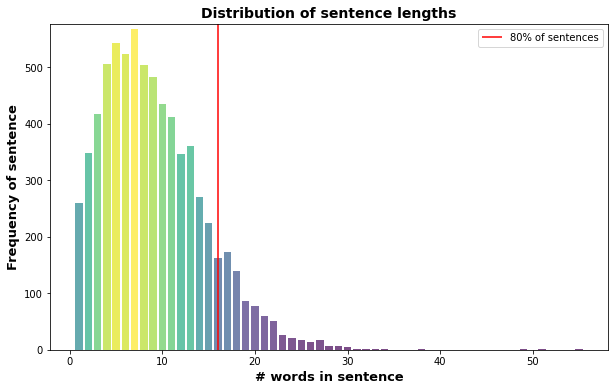

Decision boundary / 80 pct of sentence lengths is: 16


In [53]:
# VISUALIZE SENTENCE LENGTHS AND DECISION BOUNDARY
decision_boundary = plot_sentence_lengths(train_data)
print("Decision boundary / 80 pct of sentence lengths is:", decision_boundary)

In [58]:
# ONE-HOT TARGET (GENDER)
classes = [-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
n_unique_classes = len(classes)

def round_list(list):
    rounded_pols = []
    for seq in list:
        rounded_pols.append([round(pol,1) for pol in seq])
    return rounded_pols

def encode_list(list):
    le = LabelEncoder()
    le.fit_transform(classes)

    encoded_pols = []
    for seq in list:
        encoded_pols.append(le.transform(seq))
    return encoded_pols

def one_hot_list(list):
    one_hot_pols = []
    for seq in list:
        one_hot_pols.append([to_categorical(pol, n_unique_classes) for pol in seq])
    return one_hot_pols

train_pols_rounded = round_list(train_data['Polarity'])
train_pols_encoded = encode_list(train_pols_rounded)
y_train = one_hot_list(train_pols_encoded)

test_pols_rounded = round_list(test_data['Polarity'])
test_pols_encoded = encode_list(test_pols_rounded)
y_test = one_hot_list(test_pols_encoded)


print("Unique polarities:", [classes])
print("Unique polarities:", encode_list([classes]))

print("\nTraining data example polarity sequence:", train_data['Polarity'][:1].tolist())
print("Training data example polarity sequence rounded:", train_pols_rounded[0])
print("Training data example polarity sequence encoded:", train_pols_encoded[0])
print("Training data example polarity sequence one-hot:", y_train[0])

print("\nTest data example polarity sequence:", test_data['Polarity'][:1].tolist())
print("Test data example polarity sequence rounded:", test_pols_rounded[0])
print("Test data example polarity sequence encoded:", test_pols_encoded[0])
print("Test data example polarity sequence one-hot:", y_test[0])

Unique polarities: [[-1.0, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]]
Unique polarities: [array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20], dtype=int64)]

Training data example polarity sequence: [[0.050219108073258, -0.265826402541593, -0.08213922234331, -0.062766330332991]]
Training data example polarity sequence rounded: [0.1, -0.3, -0.1, -0.1]
Training data example polarity sequence encoded: [11  7  9  9]
Training data example polarity sequence one-hot: [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.], dtype=float32), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
 

In [70]:
# ENCODE FEATURES TO INTEGERS, EQUAL LENGTHS AND PAD
# Inspired by: https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/
def encode_feature(train_data_, test_data_):
    tokenizer = Tokenizer()
    # ONLY FIT ON TRAIN DATA
    tokenizer.fit_on_texts(train_data_)
    return tokenizer.texts_to_sequences(train_data_), tokenizer.texts_to_sequences(test_data_), len(tokenizer.word_index)

train_data['Lemma_enc'], test_data['Lemma_enc'], vocab_size = encode_feature(train_data['Lemma'], test_data['Lemma'])


trunc_type = 'post'
padding_type = 'post'
max_len = decision_boundary

X_train = pad_sequences(train_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
X_test = pad_sequences(test_data['Lemma_enc'], dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

y_train = pad_sequences(y_train, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)
y_test = pad_sequences(y_test, dtype='float32', padding=padding_type, truncating=trunc_type, maxlen=max_len)

In [71]:
# DEFINING KERAS CALLBACKS

# Borrowed from: https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

# root_logdir = os.path.join(os.curdir, "./logged_models/" + model_name + '/' + model_variant)
# def get_run_logdir():
#     run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
#     return os.path.join(root_logdir, run_id)

# run_log_dir = get_run_logdir()
# file_writer = tf.summary.create_file_writer(run_log_dir + "/metrics")
# file_writer.set_as_default()

# tensorboard_cb = tf.keras.callbacks.TensorBoard(run_log_dir)

# my_callbacks = [earlystopping, tensorboard_cb]
my_callbacks = [earlystopping]

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 16, 128)           1046912   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 16, 256)           263168    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 16, 128)           164352    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 21)            2709      
Total params: 1,477,141
Trainable params: 1,477,141
Non-trainable params: 0
_________________________________________________________________


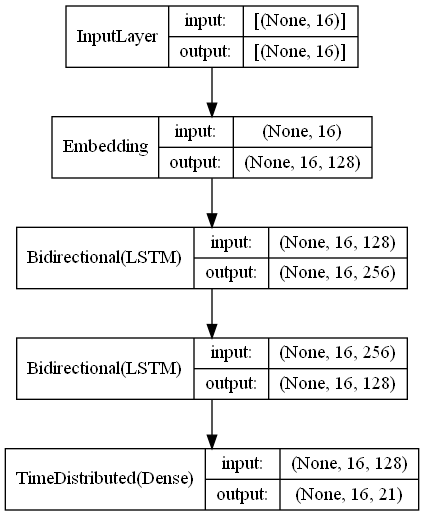

In [72]:
# DEFINING AND PLOTTING MODEL
embedding_dim = 128

model = tf.keras.Sequential([
    layers.Embedding(vocab_size+1, embedding_dim, input_length=max_len),
    layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)),
    layers.TimeDistributed(layers.Dense(n_unique_classes, activation="softmax"))
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # cross entropy loss chapter 4 HOML - categorial crossentropy because to_categorial 

model.summary()

plot_model(model, show_shapes=True, show_layer_names=False)

In [73]:
# FITTING MODEL

history = model.fit(X_train, y_train, epochs=20, callbacks=my_callbacks, validation_split=0.2)

Epoch 1/20
177/177 [==============================] - 22s 79ms/step - loss: 0.7798 - accuracy: 0.3084 - val_loss: 0.4575 - val_accuracy: 0.4123
Epoch 2/20
177/177 [==============================] - 13s 76ms/step - loss: 0.2238 - accuracy: 0.4762 - val_loss: 0.1019 - val_accuracy: 0.5235
Epoch 3/20
177/177 [==============================] - 14s 80ms/step - loss: 0.0658 - accuracy: 0.5272 - val_loss: 0.0414 - val_accuracy: 0.5390
Epoch 4/20
177/177 [==============================] - 14s 76ms/step - loss: 0.0339 - accuracy: 0.5329 - val_loss: 0.0307 - val_accuracy: 0.5392
Epoch 5/20
177/177 [==============================] - 13s 76ms/step - loss: 0.0245 - accuracy: 0.5341 - val_loss: 0.0271 - val_accuracy: 0.5394
Epoch 6/20
177/177 [==============================] - 14s 77ms/step - loss: 0.0193 - accuracy: 0.5351 - val_loss: 0.0260 - val_accuracy: 0.5407
Epoch 7/20
177/177 [==============================] - 14s 79ms/step - loss: 0.0150 - accuracy: 0.5364 - val_loss: 0.0255 - val_accuracy:

red is training, blue is validation


<Figure size 432x288 with 0 Axes>

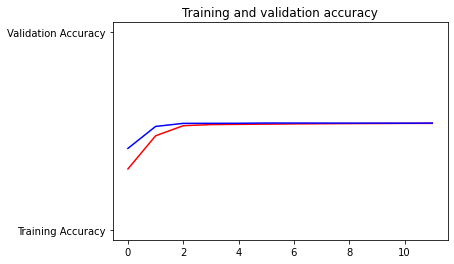

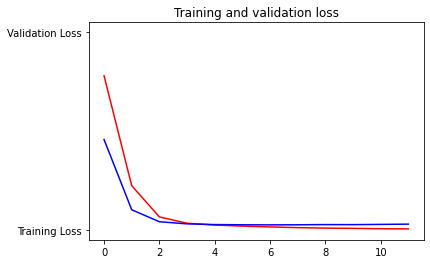

<Figure size 432x288 with 0 Axes>

In [74]:
# PLOTTING HISTORY OF FITTING
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')

print("red is training, blue is validation")
plt.figure()

In [ ]:
# SAVING MODEL
# model.save('saved_models/' + model_name + '/' + model_variant + '.h5')

In [99]:
# PREDICT TEST DATA
y_pred = model.predict(X_test)
cm_pred = y_pred.argmax(axis=-1).flatten()
cm_true = y_test.argmax(axis=-1).flatten()

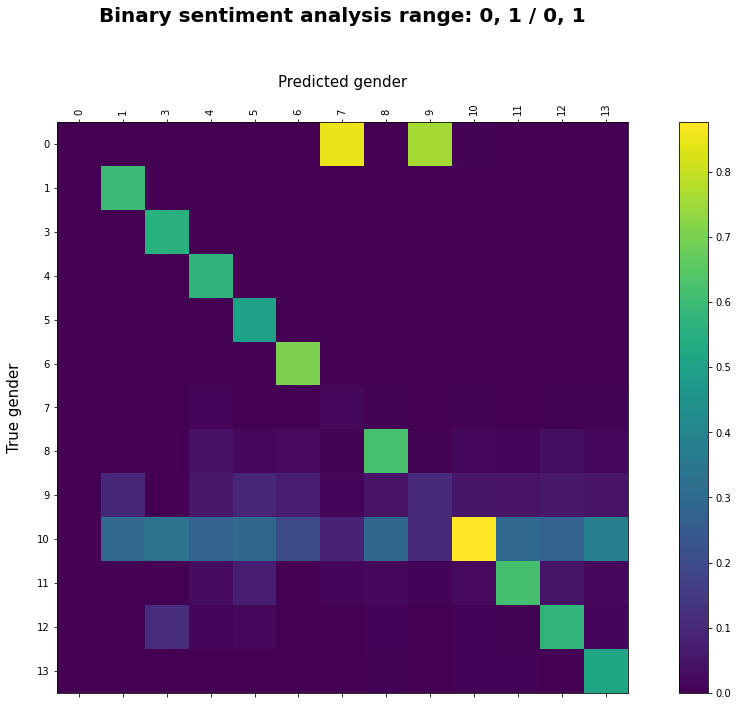

In [116]:
# PLOTTING CONFUSION MATRIX
# y_test = np.array(y_test).flatten()
cm = confusion_matrix(cm_true, cm_pred, normalize='pred')

fig = plt.figure( figsize=[18.5,10.5])
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
ax.set_xlabel('Predicted gender', fontsize = 15, labelpad=15.0)
ax.xaxis.set_label_position('top')
ax.set_ylabel('True gender', fontsize = 15, labelpad=15.0)
ax.set_title('Binary sentiment analysis range: 0, 1 / 0, 1',fontweight="bold", size=20, pad=100.0)

cm_axis_vals = []

for x in np.unique(np.array(np.concatenate((cm_true,cm_pred)))):
    cm_axis_vals.append(x)

fig.colorbar(cax)
plt.xticks(range(len(cm_axis_vals)), cm_axis_vals, rotation=90)
plt.yticks(range(len(cm_axis_vals)), cm_axis_vals)
plt.show()

In [117]:
# PRINTING METRICS
from sklearn.metrics import classification_report

report = classification_report(cm_true, cm_pred, output_dict=True)
df_perf = pd.DataFrame.from_dict(report).transpose()
df_perf_2 = df_perf[:len(cm_axis_vals)]
df_perf_2.insert(loc=0, column='Polarity', value=cm_axis_vals)
df_perf_2.precision = df_perf_2.precision.round(2)
df_perf_2.recall = df_perf_2.recall.round(2)
df_perf_2['f1-score'] = df_perf_2['f1-score'].round(2)
df_perf_2.support = df_perf_2.support.round()
df_perf_2.reset_index(drop=True, inplace=True)


df_perf_2

C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\hanse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: Unde

,Polarity,precision,recall,f1-score,support
0,0,0.00,0.00,0.00,21164.0
1,1,0.60,0.60,0.60,10.0
2,3,0.56,0.42,0.48,12.0
3,4,0.57,0.59,0.58,69.0
4,5,0.50,0.51,0.50,53.0
5,6,0.70,0.73,0.72,85.0
6,7,0.02,0.76,0.04,293.0
7,8,0.62,0.64,0.63,946.0
8,9,0.11,0.71,0.19,2392.0
9,10,0.88,0.63,0.73,9866.0


In [ ]:
# DEFINE XAI FUNCTION
%reload_ext autoreload
%autoreload 2
from classes.data_prepper import DataPrepper

# Borrowed from: https://www.geeksforgeeks.org/python-program-to-find-n-largest-elements-from-a-list/
# Function returns N largest elements
def Nmaxelements(list, N):
    return list[:N]

def find_complete_sentence(sentence_number, sentences):
    index = sentences.index[sentences['Sentence #'] == sentence_number].tolist()[0]
    return sentences['Text'][index]

def XAI(predictions, input_data, N_greatest_polarities):
    p = DataPrepper()
    complete_sentences = pd.read_json('../datasets/7_sentences.json')

    for pred, row in zip(predictions, input_data.iterrows()):
        data = row[1]

        print("\n---------------------------------------------------------------------------------------")
        print("The sentence:", '"'+find_complete_sentence(data['Sentence #'], complete_sentences)+'".\n')
        print("Was predicted to be", 'masculine' if pred == 0 else 'feminine', "("+str(pred)+").\n")

        print("Most", 'masculine' if pred == 0 else 'feminine', "words in sentence are:\n")
        greatest_pols = []

        if (pred == 0):
            greatest_pols = Nmaxelements(sorted(data['Polarity']), N_greatest_polarities)
        else:
            greatest_pols = Nmaxelements(sorted(data['Polarity'], reverse=True), N_greatest_polarities)

        for pol in greatest_pols:
            i = data['Polarity'].index(pol)
            print("'"+data["Word"][i]+"'", "with a polarity of", round(pol,2))
        

In [ ]:
# USE XAI ON PREDICTIONS
XAI(y_pred[:100], test_data, 2)

constructor of DataPrepper

---------------------------------------------------------------------------------------
The sentence: "well, we're guessing that won't catch on as easily.".

Was predicted to be masculine (0).

Most masculine words in sentence are:

'won' with a polarity of -0.36
'catch' with a polarity of -0.05

---------------------------------------------------------------------------------------
The sentence: "Misha Janette's whirlwind of wacky outfits, street style, inspiration and knowledge of Japanese fashion comes to fruition.".

Was predicted to be feminine (1).

Most feminine words in sentence are:

'fashion' with a polarity of 0.25
'style' with a polarity of 0.21

---------------------------------------------------------------------------------------
The sentence: "And, if the patient should get tired of the new look, they can be assured that this filler (and the "look") will gradually disappear in time.".

Was predicted to be feminine (1).

Most feminine words in